In [1]:
### Load PPS model
%run ./HC_model.ipynb

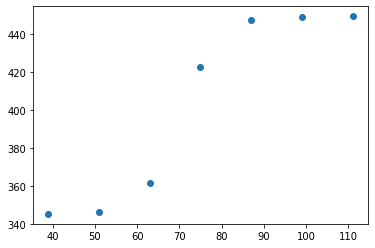

In [2]:
### Audio-tactile experiment simulation setup

## Calculate distance in cms. Speaker is positioned at 100cm from the hand.
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 7)
v = 30  # cm/s
a_distances = 120 - ts * v  # distance points in cm (network coordinates)

## Simulation setup
simtime = 100  # ms

## Synapses setup
b = 2.5
pr = 0

# Experimental Data
ymin = 345.10584283635757
ymax = 449.60233625307154
cp = 120 - 1.654 * v
slope = 1 / 0.23
SCZ_RTs = RTsig(a_distances, cp, slope)
plt.scatter(a_distances, SCZ_RTs)

In [4]:
def sczmodelrun(theta):
    sczRTs, ZMs, ZTs, ZAs = experimentrun(
        a_distances, simtime, b, theta[0], 0.15, 0.05, 1, 4
    )
    xf = sczRTs
    yf = SCZ_RTs

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 6.5)]
res = differential_evolution(sczmodelrun, bounds, disp=True)

differential_evolution step 1: f(x)= 97.222
differential_evolution step 2: f(x)= 97.222
differential_evolution step 3: f(x)= 97.222


In [5]:
print(res)

     fun: 97.22200364161547
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 3
 success: True
       x: array([2.20191947])


In [8]:
sczRTs, ZMs, ZTs, ZAs = experimentrun(
    a_distances, simtime, b, 2.20191947, 0.15, 0.05, 1, 4
)

3.350439238742615 153.67178224101866


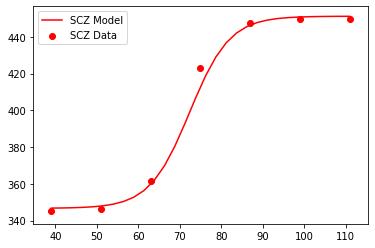

In [9]:
xf = sczRTs
yf = SCZ_RTs
m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
    xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
)
bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

ymin, ymax = np.min(m * xf + bias), np.max(m * xf + bias)
dc, h = sigfit(a_distances, m * xf + bias)
a_distances_exp = np.linspace(a_distances[0], a_distances[-1], 30)
yf_exp = RTsig(a_distances_exp, dc, h)

plt.figure(1)
plt.plot(a_distances_exp, yf_exp, label="SCZ Model", color="r")
plt.scatter(a_distances, yf, label="SCZ Data", color="r")
plt.legend()
print(m, bias)

In [13]:
sczres = np.asarray([yf_exp, yf])
np.save("scz_pr.npy", sczres)

In [8]:
from sklearn import metrics

print(metrics.mean_squared_error(yf, m * xf + bias, squared=False))

4.933357483591761


In [12]:
def adjrmse(model, data, k):
    sse = np.sum(np.square(data - model))
    n = len(model)
    return np.sqrt(sse / (n - k))


scz_error = adjrmse(m * xf + bias, sczres[1], 3)
print(scz_error)

6.526218515081606
